In [3]:
# !pip install opencv-python

In [4]:
# pip listA

Exploration vs. Exploitation:
- This project uses Noisy Networks (Noisy Nets) for exploration, a feature of the Rainbow DQN algorithm. Rather than manually decaying an ε in ε-greedy policies, Noisy Nets inject learnable, parameterized noise into the model’s layers. This encourages diverse behavior early in training and naturally reduces randomness as the agent becomes more confident, effectively balancing exploration and exploitation over time.

C:\Users\marta\AppData\Local\Temp\ipykernel_15144\2344429951.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🌀 Step 0, Buffer size: 0


C:\Users\marta\AppData\Local\Temp\ipykernel_15144\2144615492.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  torch.tensor(s, dtype=torch.float32),


🔥 Non-zero reward at step 821: 3.0
 Episode 1 finished at step 999 — Reward: 3.00
🔥 Non-zero reward at step 1209: 7.0
🔥 Non-zero reward at step 1417: 3.0
🔥 Non-zero reward at step 1825: 3.0
 Episode 2 finished at step 1999 — Reward: 13.00
🔥 Non-zero reward at step 2213: 3.0
🔥 Non-zero reward at step 2629: 3.0
 Episode 3 finished at step 2999 — Reward: 6.00
🔥 Non-zero reward at step 3612: 6.0
 Episode 4 finished at step 3999 — Reward: 6.00
🔥 Non-zero reward at step 4992: 13.0
 Episode 5 finished at step 4999 — Reward: 13.00
🌀 Step 5000, Buffer size: 4995
 Episode 6 finished at step 5999 — Reward: 0.00
🔥 Non-zero reward at step 6833: 1.0
 Episode 7 finished at step 6999 — Reward: 1.00
🔥 Non-zero reward at step 7417: 7.0
 Episode 8 finished at step 7999 — Reward: 7.00
 Episode 9 finished at step 8999 — Reward: 0.00
🔥 Non-zero reward at step 9859: 6.0
 Episode 10 finished at step 9999 — Reward: 6.00
🌀 Step 10000, Buffer size: 9990
 Episode 11 finished at step 10999 — Reward: 0.00
🔥 Non-zer

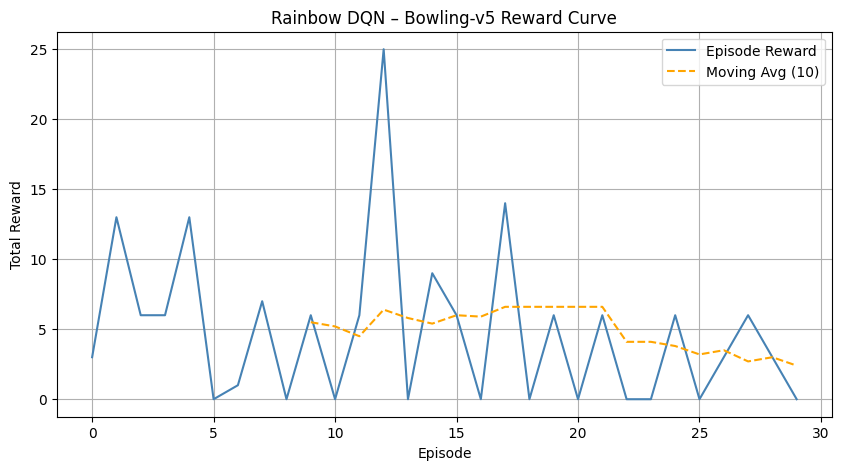


 Checking convergence: threshold = 5.0, window = 10 episodes
 Convergence detected at episode 10:
   • Moving Average: 5.50
   • Range: Episodes 1 to 10


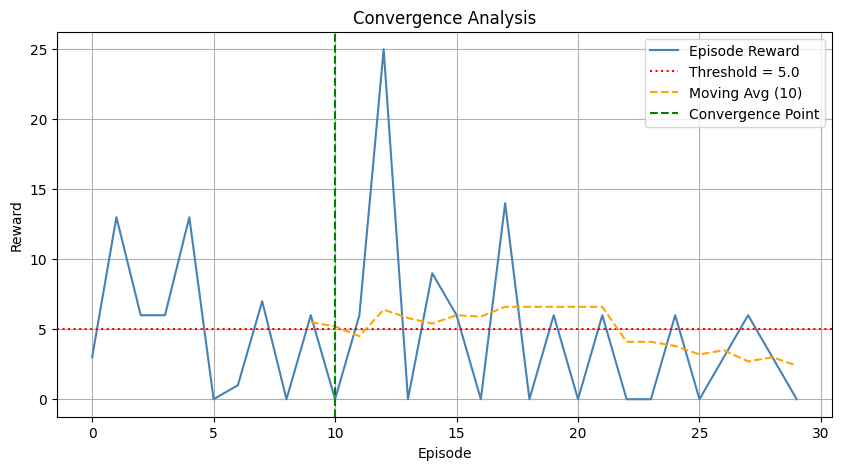

 Success Rate: 50.00% (15 / 30 episodes ≥ 5.0 points)
 Evaluation Episode 1: Reward = 0.00
 Evaluation Episode 2: Reward = 0.00
 Evaluation Episode 3: Reward = 0.00
 Evaluation Episode 4: Reward = 0.00
 Evaluation Episode 5: Reward = 0.00

 Average Reward over 5 episodes: 0.00


[0.0, 0.0, 0.0, 0.0, 0.0]

In [14]:
from torch.amp import autocast  # ✅ NEW AMP import
from torch.cuda.amp import GradScaler

# -------------------- CONFIGURATION --------------------
TOTAL_TIMESTEPS = 30_000
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
EVAL_EVERY = 25_000
MAX_STEPS_PER_EPISODE = 1000
N_STEP = 2
GAMMA = 0.99
WARMUP_STEPS = 500
TARGET_UPDATE_FREQ = 20_000
LOG_FREQ = 5000
REWARD_LOG_FILE = "rainbow_bowling_rewards.csv"
SUCCESS_THRESHOLD = 5.0
# ------------------------------------------------------

# -------------------- SETUP --------------------
buffer = PrioritizedReplayBuffer()
n_step_buffer = deque(maxlen=N_STEP)
n_gamma = GAMMA ** N_STEP

state, _ = env.reset()
episode_reward = 0
episode_count = 0
episode_step_count = 0
best_reward = float('-inf')

optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()

for t in range(TOTAL_TIMESTEPS):
    if t < WARMUP_STEPS:
        action = env.action_space.sample()
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.act(state_tensor)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    episode_step_count += 1
    done = done or (episode_step_count >= MAX_STEPS_PER_EPISODE)

    if reward != 0:
        print(f"🔥 Non-zero reward at step {t}: {reward}")

    n_step_buffer.append((state, action, reward, next_state, done))
    if len(n_step_buffer) == N_STEP:
        ns, na, nr, ns2, nd = compute_n_step_transition(n_step_buffer)
        buffer.add(ns, na, nr, ns2, nd)

    episode_reward, episode_count, state = track_reward(
        episode_reward, episode_count, reward, done, t, env, next_state
    )

    if done:
        episode_step_count = 0
        n_step_buffer.clear()

    # Training step
    if len(buffer) > BATCH_SIZE:
        s, a, r, s2, d, weights, idxs = buffer.sample(BATCH_SIZE)
        s = s.to(device)
        s2 = s2.to(device)
        a = a.to(device)
        r = r.to(device)
        d = d.to(device)
        weights = weights.to(device)

        with autocast("cuda"):  # ✅ Correct AMP usage
            dist = agent(s)
            dist = dist[range(BATCH_SIZE), a]

            with torch.no_grad():
                next_dist = target_agent(s2)
                next_q = torch.sum(next_dist * agent.supports, dim=2)
                next_action = torch.argmax(next_q, dim=1)
                next_dist = next_dist[range(BATCH_SIZE), next_action]

                Tz = r.unsqueeze(1) + GAMMA * agent.supports.unsqueeze(0) * (1 - d.unsqueeze(1))
                Tz = Tz.clamp(agent.Vmin, agent.Vmax)

                b = (Tz - agent.Vmin) / ((agent.Vmax - agent.Vmin) / agent.num_atoms)
                l = b.floor().clamp(0, agent.num_atoms - 1).long()
                u = b.ceil().clamp(0, agent.num_atoms - 1).long()

                offset = torch.arange(BATCH_SIZE, device=device).unsqueeze(1) * agent.num_atoms
                l_idx = (l + offset).view(-1)
                u_idx = (u + offset).view(-1)

                proj_dist = torch.zeros(BATCH_SIZE * agent.num_atoms, device=device)
                next_dist = next_dist.view(-1)
                b = b.view(-1)
                l = l.view(-1)
                u = u.view(-1)

                proj_dist.index_add_(0, l_idx, next_dist * (u.float() - b))
                proj_dist.index_add_(0, u_idx, next_dist * (b - l.float()))
                m = proj_dist.view(BATCH_SIZE, agent.num_atoms)

            log_dist = torch.log(dist + 1e-6)
            loss_per_sample = -(m * log_dist).sum(1)
            loss = (loss_per_sample * weights).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        agent.reset_noise()

        td_error = loss_per_sample.detach()
        buffer.update_priorities(idxs, td_error)

    if t % TARGET_UPDATE_FREQ == 0:
        target_agent.load_state_dict(agent.state_dict())

    if t % EVAL_EVERY == 0 and episode_count > 5:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"📊 Step {t}: Avg Last 10 Ep Reward = {avg_reward:.2f}")

    if t % LOG_FREQ == 0:
        print(f"🌀 Step {t}, Buffer size: {len(buffer)}")

# -------------------- Final Evaluation & Reporting --------------------

save_rewards_csv(REWARD_LOG_FILE)
plot_rewards("Rainbow DQN – Bowling-v5 Reward Curve", window=10)
estimate_convergence_verbose(episode_rewards, threshold=SUCCESS_THRESHOLD, window=10)
compute_success_rate(episode_rewards, threshold=SUCCESS_THRESHOLD)
evaluate_agent(agent, env, episodes=5, device=device)


C:\Users\marta\AppData\Local\Temp\ipykernel_15144\2725879308.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🌀 Step 0, Buffer size: 0
🔥 Non-zero reward at step 417: 3.0
 Episode 1 finished at step 999 — Reward: 3.00
 Episode 2 finished at step 1999 — Reward: 0.00
 Episode 3 finished at step 2999 — Reward: 0.00
🔥 Non-zero reward at step 3405: 6.0
 Episode 4 finished at step 3999 — Reward: 6.00
🔥 Non-zero reward at step 4207: 6.0
 Episode 5 finished at step 4999 — Reward: 6.00
🌀 Step 5000, Buffer size: 4990
 Episode 6 finished at step 5999 — Reward: 0.00
 Episode 7 finished at step 6999 — Reward: 0.00
 Episode 8 finished at step 7999 — Reward: 0.00
🔥 Non-zero reward at step 8208: 3.0
 Episode 9 finished at step 8999 — Reward: 3.00
 Episode 10 finished at step 9999 — Reward: 0.00
🌀 Step 10000, Buffer size: 9980
🔥 Non-zero reward at step 10809: 7.0
 Episode 11 finished at step 10999 — Reward: 7.00
 Episode 12 finished at step 11999 — Reward: 0.00
 Episode 13 finished at step 12999 — Reward: 0.00
🔥 Non-zero reward at step 13809: 3.0
 Episode 14 finished at step 13999 — Reward: 3.00
🔥 Non-zero rewa

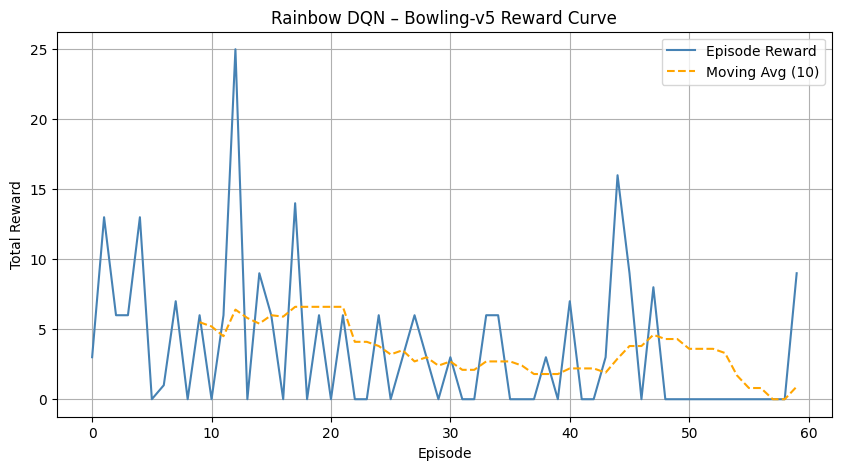


 Checking convergence: threshold = 5.0, window = 10 episodes
 Convergence detected at episode 10:
   • Moving Average: 5.50
   • Range: Episodes 1 to 10


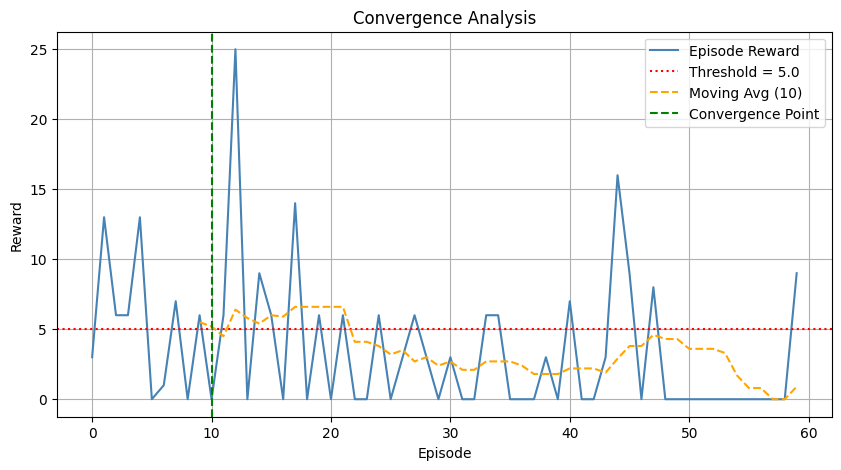

 Success Rate: 36.67% (22 / 60 episodes ≥ 5.0 points)
 Evaluation Episode 1: Reward = 0.00
 Evaluation Episode 2: Reward = 0.00
 Evaluation Episode 3: Reward = 0.00
 Evaluation Episode 4: Reward = 0.00
 Evaluation Episode 5: Reward = 0.00

 Average Reward over 5 episodes: 0.00


[0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
from torch.amp import autocast  # ✅ NEW AMP import
from torch.cuda.amp import GradScaler

# -------------------- CONFIGURATION --------------------
TOTAL_TIMESTEPS = 30_000
BATCH_SIZE = 64
LEARNING_RATE = 5e-5
EVAL_EVERY = 25_000
MAX_STEPS_PER_EPISODE = 1000
N_STEP = 3
GAMMA = 0.99
WARMUP_STEPS = 500
TARGET_UPDATE_FREQ = 20_000
LOG_FREQ = 5000
REWARD_LOG_FILE = "rainbow_bowling_rewards.csv"
SUCCESS_THRESHOLD = 5.0
# ------------------------------------------------------

# -------------------- SETUP --------------------
buffer = PrioritizedReplayBuffer()
n_step_buffer = deque(maxlen=N_STEP)
n_gamma = GAMMA ** N_STEP

state, _ = env.reset()
episode_reward = 0
episode_count = 0
episode_step_count = 0
best_reward = float('-inf')

optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()

for t in range(TOTAL_TIMESTEPS):
    if t < WARMUP_STEPS:
        action = env.action_space.sample()
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.act(state_tensor)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    episode_step_count += 1
    done = done or (episode_step_count >= MAX_STEPS_PER_EPISODE)

    if reward != 0:
        print(f"🔥 Non-zero reward at step {t}: {reward}")

    n_step_buffer.append((state, action, reward, next_state, done))
    if len(n_step_buffer) == N_STEP:
        ns, na, nr, ns2, nd = compute_n_step_transition(n_step_buffer)
        buffer.add(ns, na, nr, ns2, nd)

    episode_reward, episode_count, state = track_reward(
        episode_reward, episode_count, reward, done, t, env, next_state
    )

    if done:
        episode_step_count = 0
        n_step_buffer.clear()

    # Training step
    if len(buffer) > BATCH_SIZE:
        s, a, r, s2, d, weights, idxs = buffer.sample(BATCH_SIZE)
        s = s.to(device)
        s2 = s2.to(device)
        a = a.to(device)
        r = r.to(device)
        d = d.to(device)
        weights = weights.to(device)

        with autocast("cuda"):  # ✅ Correct AMP usage
            dist = agent(s)
            dist = dist[range(BATCH_SIZE), a]

            with torch.no_grad():
                next_dist = target_agent(s2)
                next_q = torch.sum(next_dist * agent.supports, dim=2)
                next_action = torch.argmax(next_q, dim=1)
                next_dist = next_dist[range(BATCH_SIZE), next_action]

                Tz = r.unsqueeze(1) + GAMMA * agent.supports.unsqueeze(0) * (1 - d.unsqueeze(1))
                Tz = Tz.clamp(agent.Vmin, agent.Vmax)

                b = (Tz - agent.Vmin) / ((agent.Vmax - agent.Vmin) / agent.num_atoms)
                l = b.floor().clamp(0, agent.num_atoms - 1).long()
                u = b.ceil().clamp(0, agent.num_atoms - 1).long()

                offset = torch.arange(BATCH_SIZE, device=device).unsqueeze(1) * agent.num_atoms
                l_idx = (l + offset).view(-1)
                u_idx = (u + offset).view(-1)

                proj_dist = torch.zeros(BATCH_SIZE * agent.num_atoms, device=device)
                next_dist = next_dist.view(-1)
                b = b.view(-1)
                l = l.view(-1)
                u = u.view(-1)

                proj_dist.index_add_(0, l_idx, next_dist * (u.float() - b))
                proj_dist.index_add_(0, u_idx, next_dist * (b - l.float()))
                m = proj_dist.view(BATCH_SIZE, agent.num_atoms)

            log_dist = torch.log(dist + 1e-6)
            loss_per_sample = -(m * log_dist).sum(1)
            loss = (loss_per_sample * weights).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        agent.reset_noise()

        td_error = loss_per_sample.detach()
        buffer.update_priorities(idxs, td_error)

    if t % TARGET_UPDATE_FREQ == 0:
        target_agent.load_state_dict(agent.state_dict())

    if t % EVAL_EVERY == 0 and episode_count > 5:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"📊 Step {t}: Avg Last 10 Ep Reward = {avg_reward:.2f}")

    if t % LOG_FREQ == 0:
        print(f"🌀 Step {t}, Buffer size: {len(buffer)}")

# -------------------- Final Evaluation & Reporting --------------------

save_rewards_csv(REWARD_LOG_FILE)
plot_rewards("Rainbow DQN – Bowling-v5 Reward Curve", window=10)
estimate_convergence_verbose(episode_rewards, threshold=SUCCESS_THRESHOLD, window=10)
compute_success_rate(episode_rewards, threshold=SUCCESS_THRESHOLD)
evaluate_agent(agent, env, episodes=5, device=device)


In [15]:
# # -------------------- Setup --------------------
# buffer = ReplayBuffer()
# state, _ = env.reset()
# total_timesteps = 100_000
# batch_size = 32
# gamma = 0.99

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

# episode_reward = 0
# episode_count = 0

# # -------------------- Training Loop --------------------
# for t in range(total_timesteps):
#     # Select action
#     state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#     action = agent.act(state_tensor)

#     # Take action in env
#     next_state, reward, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated

#     # Store experience
#     buffer.add(state, action, reward, next_state, done)

#     # Track reward and episode
#     episode_reward, episode_count, state = track_reward(
#         episode_reward, episode_count, reward, done, t, env, next_state
#     )

#     # Training step
#     if len(buffer) > batch_size:
#         s, a, r, s2, d = buffer.sample(batch_size)
#         s, a, r, s2, d = s.to(device), a.to(device), r.to(device), s2.to(device), d.to(device)

#         # Current Q-distribution
#         dist = agent(s)
#         dist = dist[range(batch_size), a]
#         q_estimate = torch.sum(dist * agent.supports, dim=1)

#         # Next Q-distribution (Double DQN logic)
#         next_dist = agent(s2)
#         next_q = torch.sum(next_dist * agent.supports, dim=2)
#         next_action = torch.argmax(next_q, dim=1)
#         next_dist = next_dist[range(batch_size), next_action]

#         # Bellman projection
#         Tz = r.unsqueeze(1) + gamma * agent.supports.unsqueeze(0) * (1 - d.unsqueeze(1))
#         Tz = Tz.clamp(agent.Vmin, agent.Vmax)

#         b = (Tz - agent.Vmin) / ((agent.Vmax - agent.Vmin) / agent.num_atoms)
#         l = b.floor().clamp(0, agent.num_atoms - 1).long()
#         u = b.ceil().clamp(0, agent.num_atoms - 1).long()

#         m = torch.zeros(batch_size, agent.num_atoms).to(device)
#         for i in range(batch_size):
#             for j in range(agent.num_atoms):
#                 lj, uj, pj = l[i][j], u[i][j], next_dist[i][j]
#                 if lj == uj:
#                     m[i][lj] += pj
#                 else:
#                     m[i][lj] += pj * (uj - b[i][j])
#                     m[i][uj] += pj * (b[i][j] - lj)

#         # Loss and optimization
#         log_dist = torch.log(dist + 1e-6)
#         loss = -(m * log_dist).sum(1).mean()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         agent.reset_noise()

#     # Optional: Log every 5000 steps
#     if t % 5000 == 0:
#         print(f"🌀 Step {t}, Buffer size: {len(buffer)}")

# # -------------------- Evaluation --------------------

# # Save rewards
# save_rewards_csv("rainbow_bowling_rewards.csv")

# # Plot learning progress
# plot_rewards("Rainbow DQN – Bowling-v5 Reward Curve", window=10)

# # Estimate convergence
# estimate_convergence_verbose(episode_rewards, threshold=5.0, window=10)

# # Calculate success rate
# compute_success_rate(episode_rewards, threshold=5.0)

# # Final agent evaluation (greedy)
# evaluate_agent(agent, env, episodes=5, device=device)


In [16]:
# # -------------------- Setup --------------------
# buffer = PrioritizedReplayBuffer()
# n_step = 3
# gamma = 0.99
# n_gamma = gamma ** n_step
# n_step_buffer = deque(maxlen=n_step)

# state, _ = env.reset()
# episode_reward = 0
# episode_count = 0
# episode_step_count = 0
# max_steps_per_episode = 1000
# eval_every = 25000
# total_timesteps = 1_000_000
# batch_size = 64
# best_reward = float('-inf')
# learning_rate = 5e-5
# optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

# for t in range(total_timesteps):
#     # Warm-up exploration phase
#     if t < 1000:
#         action = env.action_space.sample()
#     else:
#         state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#         action = agent.act(state_tensor)

#     # Take action
#     next_state, reward, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated
#     episode_step_count += 1
#     done = done or (episode_step_count >= max_steps_per_episode)

#     if reward != 0:
#         print(f"🔥 Non-zero reward at step {t}: {reward}")

#     n_step_buffer.append((state, action, reward, next_state, done))
#     if len(n_step_buffer) == n_step:
#         ns, na, nr, ns2, nd = compute_n_step_transition(n_step_buffer)
#         buffer.add(ns, na, nr, ns2, nd)

#     episode_reward, episode_count, state = track_reward(
#         episode_reward, episode_count, reward, done, t, env, next_state
#     )
#     if done:
#         episode_step_count = 0
#         n_step_buffer.clear()

#     # Training step
#     if len(buffer) > batch_size:
#         s, a, r, s2, d, weights, idxs = buffer.sample(batch_size)

#         s = s.to(device)
#         s2 = s2.to(device)
#         a = a.to(device)
#         r = r.to(device)
#         d = d.to(device)
#         weights = weights.to(device)

#         dist = agent(s)
#         dist = dist[range(batch_size), a]

#         with torch.no_grad():
#             next_dist = target_agent(s2)
#             next_q = torch.sum(next_dist * agent.supports, dim=2)
#             next_action = torch.argmax(next_q, dim=1)
#             next_dist = next_dist[range(batch_size), next_action]

#             Tz = r.unsqueeze(1) + gamma * agent.supports.unsqueeze(0) * (1 - d.unsqueeze(1))
#             Tz = Tz.clamp(agent.Vmin, agent.Vmax)

#             b = (Tz - agent.Vmin) / ((agent.Vmax - agent.Vmin) / agent.num_atoms)
#             l = b.floor().clamp(0, agent.num_atoms - 1).long()
#             u = b.ceil().clamp(0, agent.num_atoms - 1).long()

#             m = torch.zeros(batch_size, agent.num_atoms).to(device)
#             for i in range(batch_size):
#                 for j in range(agent.num_atoms):
#                     lj, uj, pj = l[i][j], u[i][j], next_dist[i][j]
#                     if lj == uj:
#                         m[i][lj] += pj
#                     else:
#                         m[i][lj] += pj * (uj - b[i][j])
#                         m[i][uj] += pj * (b[i][j] - lj)

#         log_dist = torch.log(dist + 1e-6)
#         loss_per_sample = -(m * log_dist).sum(1)
#         loss = (loss_per_sample * weights).mean()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         agent.reset_noise()

#         # Update priorities based on TD error
#         td_error = loss_per_sample.detach()
#         buffer.update_priorities(idxs, td_error)

#     # 🔁 Target network sync every 10,000 steps
#     if t % 10000 == 0:
#         target_agent.load_state_dict(agent.state_dict())

#     # Evaluation log
#     if t % eval_every == 0 and episode_count > 5:
#         avg_reward = np.mean(episode_rewards[-10:])
#         print(f"📊 Step {t}: Avg Last 10 Ep Reward = {avg_reward:.2f}")

#     if t % 5000 == 0:
#         print(f"🌀 Step {t}, Buffer size: {len(buffer)}")

# # -------------------- Final Evaluation & Reporting --------------------

# # Save episode reward history
# save_rewards_csv("rainbow_bowling_rewards.csv")

# # Plot the full training curve
# plot_rewards("Rainbow DQN – Bowling-v5 Reward Curve", window=10)

# # Estimate convergence point
# estimate_convergence_verbose(episode_rewards, threshold=5.0, window=10)

# # Compute success rate
# compute_success_rate(episode_rewards, threshold=5.0)

# # Final greedy policy evaluation
# evaluate_agent(agent, env, episodes=5, device=device)
